### Main things to note: 

- Data Source is the Amazon forest thing
- Data is augmented 

In [1]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf


## repeated printouts and wide-format text:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=256):
    imgNames = os.listdir(imgPath)
    maskNames = os.listdir(maskPath)

    # imgAddr = imgPath + '/'
    # maskAddr = maskPath + '/'

    for i in range(len(imgNames)):
        img = plt.imread(imgPath + imgNames[i])
        mask = plt.imread(maskPath + maskNames[i])

        # Ensure the image has 4 channels
        if img.shape[2] == 4:
            # Convert 4-channel image to 3-channel by selecting the first three channels
            img = img[:, :, :3]
            mask = mask[:, :, :3]

        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))

        frameObj['img'].append(img)
        frameObj['mask'].append(mask)

    return frameObj


In [7]:
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjTrain = LoadData( framObjTrain, imgPath = 'augmentation/images/', 
                        maskPath = 'augmentation/masks/', 
                        shape = 128)

UnidentifiedImageError: cannot identify image file 'augmentation/images/S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_01_02.tif'

In [ ]:
framObjValidation = {'img' : [],
           'mask' : []
          }

framObjValidation = LoadData( framObjValidation, 
                             imgPath = 'augmentation/Validation/images/', 
                        maskPath = 'augmentation/Validation/masks/', 
                        shape = 128)

<AxesSubplot:>

<AxesSubplot:>

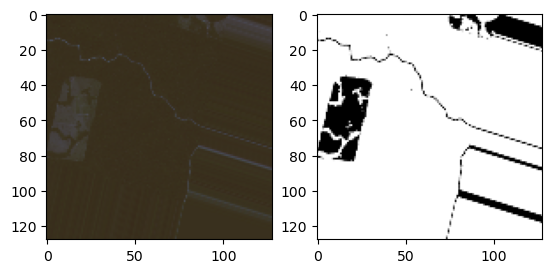

In [ ]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [ ]:
# this block essentially performs 2 convolution
#     ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, 256, 256, 3)


def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )


In [51]:
## trainign our model
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), 
                           epochs = 150, 
                           callbacks=[callback], 
                           verbose = 1,
                           validation_data=(np.array(framObjValidation['img']), np.array(framObjValidation['mask'])))

Epoch 1/150
 6/10 [=================>............] - ETA: 13s - loss: 0.1434 - accuracy: 0.0448

KeyboardInterrupt: 

<Figure size 1200x600 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Training and Validation Losses')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

<AxesSubplot:>

Text(0.5, 1.0, 'Training and Validation Accuracy')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

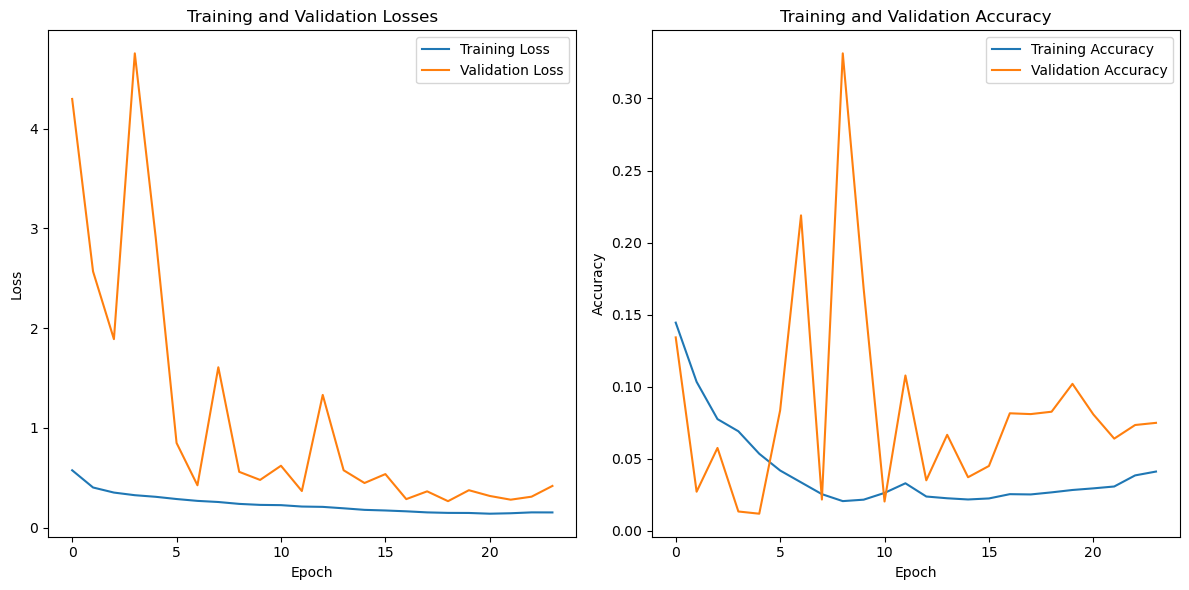

In [14]:
# Assuming you have already trained the model and stored the history in `retVal`
history = retVal.history

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask
    

    
    
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [37]:
def LoadData_testing(frameObj=None, imgPath=None, shape=256):
    imgNames = os.listdir(imgPath)
    # maskNames = os.listdir(maskPath)

    imgAddr = imgPath + '/'
    # maskAddr = maskPath + '/'

    for i in range(len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        # mask = plt.imread(maskAddr + maskNames[i])

        # Ensure the image has 4 channels
        if img.shape[2] == 4:
            # Convert 4-channel image to 3-channel by selecting the first three channels
            img = img[:, :, :3]
            # mask = mask[:, :, :3]

        img = cv2.resize(img, (shape, shape))
        # mask = cv2.resize(mask, (shape, shape))

        frameObj['img'].append(img)
        # frameObj['mask'].append(mask)

    return frameObj

framObjTest = {'img' : []}

framObjTest = LoadData_testing( framObjTest, imgPath = 'augmentation/hungry_test/',  
                        shape = 128)

In [38]:
len(framObjTest['img'])

5

In [46]:
## function for getting 16 predictions
def predict16_test (valMap, model, shape = 256):
    ## getting and proccessing val data
    print("Getting images")
    img = valMap['img']
    # mask = valMap['mask']
    # mask = mask[0:16]
    
    print("#############3")
    # imgProc = img [0:9]
    imgProc = np.array(img)
    
    print("######################## Getting predictions")
    predictions = model.predict(imgProc)

    print("######################## Is this packing?")
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc


sixteenPrediction, actuals = predict16_test(framObjTest, myTransformer, shape = 256)


Getting images
#############3
######################## Getting predictions
1/1 [==============================] - 0s 176ms/step
######################## Is this packing?


<Figure size 700x700 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'image')

<AxesSubplot:>

Text(0.5, 1.0, 'Predicted Mask')

<Figure size 700x700 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'image')

<AxesSubplot:>

Text(0.5, 1.0, 'Predicted Mask')

<Figure size 700x700 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'image')

<AxesSubplot:>

Text(0.5, 1.0, 'Predicted Mask')

<Figure size 700x700 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'image')

<AxesSubplot:>

Text(0.5, 1.0, 'Predicted Mask')

<Figure size 700x700 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'image')

<AxesSubplot:>

Text(0.5, 1.0, 'Predicted Mask')

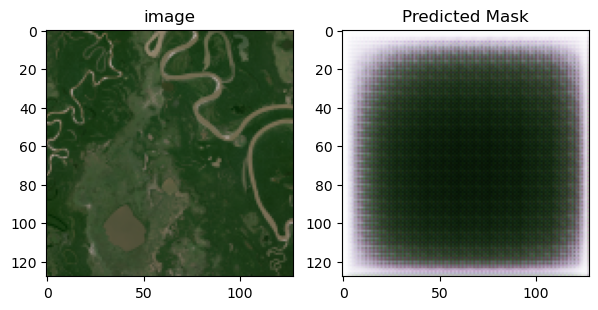

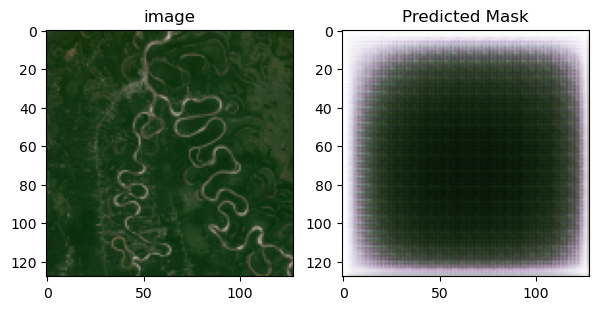

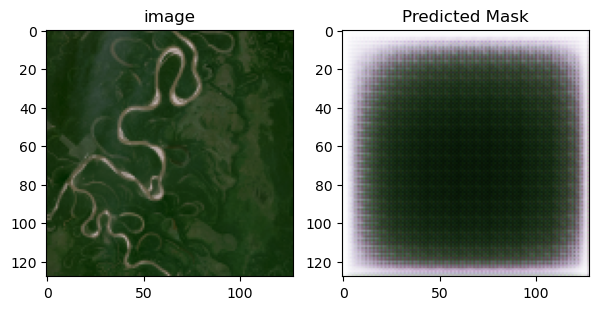

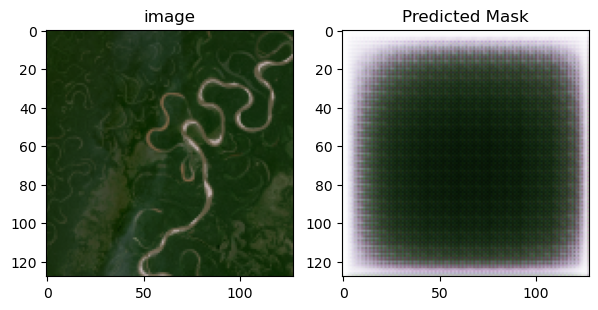

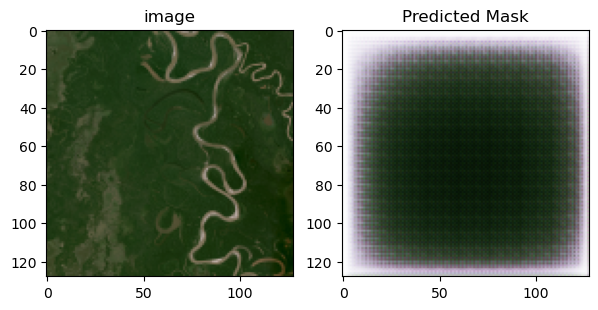

In [47]:
for i in range(len(sixteenPrediction)):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,2,1);
    plt.imshow(framObjTest['img'][i]);
    plt.title('image');
    
    plt.subplot(1,2,2);
    plt.imshow(sixteenPrediction[i]);
    plt.title('Predicted Mask');


In [28]:
base_path = 'augmentation/hungry_test/'
add_imgg = os.listdir(base_path)[0]

complete_path = base_path + add_imgg

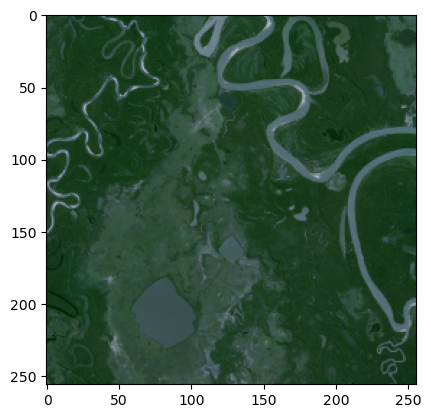

In [30]:
imgg = cv2.imread(complete_path)
plt.imshow(imgg)

In [32]:
# myTransformer.predict(imgg)


KeyError: 'mask'

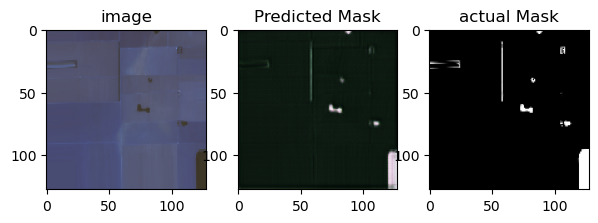

In [11]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])


In [12]:
len(actuals)

len(masks)

60

16

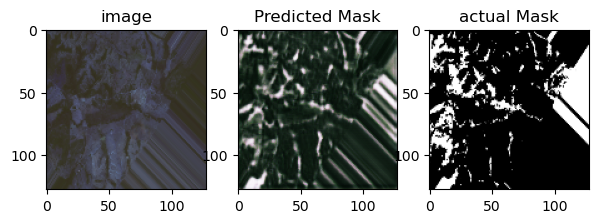

In [13]:
Plotter(actuals[14], 
        sixteenPrediction[14], 
        masks[14])
